# MATH50003 Numerical Analysis: Problem Sheet 6

This problem sheet explores condition numbers, indefinite integration,
and Euler's method.

Questions marked with a ⋆ are meant to be completed without using a computer.

In [1]:
using LinearAlgebra, Plots

## 1. Condition numbers


**Problem 1.1⋆** Prove that, if $|ϵ_i| ≤ ϵ$ and $n ϵ < 1$, then
$$
\prod_{k=1}^n (1+ϵ_i) = 1+θ_n
$$
for some constant $θ_n$ satisfying $|θ_n| ≤ {n ϵ \over 1-nϵ}$.

**Problem 1.2⋆** Let $A,B ∈ ℝ^{m × n}$. Prove that if the columns satisfy $\|𝐚_j\|_2 ≤ \| 𝐛_j\|_2$ then
$\|A\|_F ≤ \|B\|_F$ and $\|A \|_2 ≤ \sqrt{\hbox{rank}(B)} \|B\|_2$.

**Problem 1.3⋆** Compute the 1-norm, 2-norm, and ∞-norm condition numbers for the following matrices:
$$
\begin{bmatrix}
1 & 2 \\ 3 & 4
\end{bmatrix}, \begin{bmatrix}
1/3 & 1/5 \\ 0 & 1/7
\end{bmatrix}, \begin{bmatrix} 1 \\ & 1/2 \\ && ⋯ \\ &&& 1/2^n \end{bmatrix}
$$
(Hint: recall that the singular values of a matrix $A$ are the square roots of the eigenvalues of the Gram matrix
$A^⊤A$.)


**Problem 1.4**
State a bound on the relative error on $A 𝐯$ for $\|𝐯\|_2 = 1$ for the following matrices:
$$
\begin{bmatrix}
1/3 & 1/5 \\ 0 & 1/10^3
\end{bmatrix},
 \begin{bmatrix} 1 \\ & 1/2 \\ && ⋯ \\ &&& 1/2^{10} \end{bmatrix}
$$
Compute the relative error in computing $A 𝐯$ (using `big` for a high-precision version to compare against)
where $𝐯$ is the last column of $V$ in the SVD $A = U Σ V^⊤$, computed using the `svd` command with
`Float64` inputs. How does the error compare to the predicted error bound?

In [25]:
# Problem 1.4
n = 2
A = [1/3 1/5; 0.0 10^-3]
bigA = big.(A)

S = 11
ϵ = n*(2^-11)/(2-n*(2^-11))

U, Σ, Vᵀ = svd(A);
V = Vᵀ'
𝐯 = V[:,end]
bigv = big.(𝐯)
κ = Σ[1,1] * Σ[end,end]

println(norm(bigA*bigv - A*𝐯) / norm(bigA*bigv))
println(κ)

2.192574975829952309043456125256667848128708275079554960583700180948113279780777e-22
0.00033333333333333343


## 2. Indefinite integration

**Problem 2.1** Implement backward differences to approximate
indefinite-integration. How does the error compare to forward
and mid-point versions  for $f(x) = \cos x$ on the interval $[0,1]$?
Use the method to approximate the integrals of
$$
\exp(\exp x \cos x + \sin x), \prod_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x)
$$
to 3 digits, where $f^{\rm s}_{1000}(x)$ was defined in PS2.

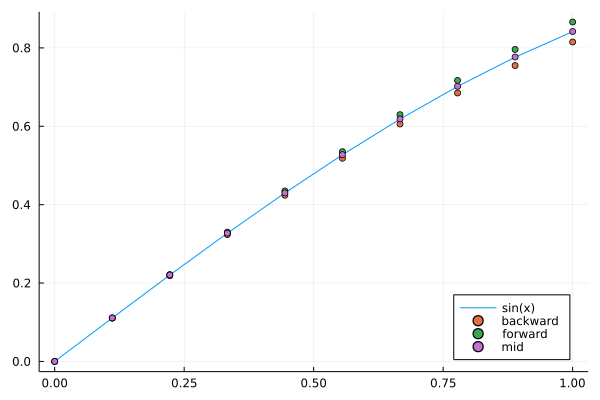

In [2]:
using LinearAlgebra, Plots

# Define the functions
f1 = x -> exp(exp(x)cos(x) + sin(x))

f2 = x -> prod([x] ./ (1:1000) .- 1)

function cont(n, x)
    ret = 2*one(x)
    for k = 1:n-1
        ret = 2 + (x-1)/ret
    end
    1 + (x-1)/ret
end


n = 10
x = range(0, 1; length=n)

function indefInt(x = x, f= x -> cos(x), c=0; m = "backward")
    h = step(x) # x[k+1]-x[k]
    n = length(x)
    L = Bidiagonal([1; fill(1/h, n-1)], fill(-1/h, n-1), :L)
    if (m=="backward")
        𝐟ᶠ = f.(x[2:end])
    elseif (m=="forward")
        𝐟ᶠ = f.(x[1:end-1])
    elseif (m=="mid")
        𝐟ᶠ = f.((x[1:end-1] + x[2:end])/2)
    end
    𝐮ᶠ = L \ [c; 𝐟ᶠ]
end

plot(x, sin.(x); label="sin(x)", legend=:bottomright)
scatter!(x, indefInt(m = "backward"); label="backward")
scatter!(x, indefInt(m = "forward"); label = "forward")
scatter!(x, indefInt(m = "mid"); label = "mid")


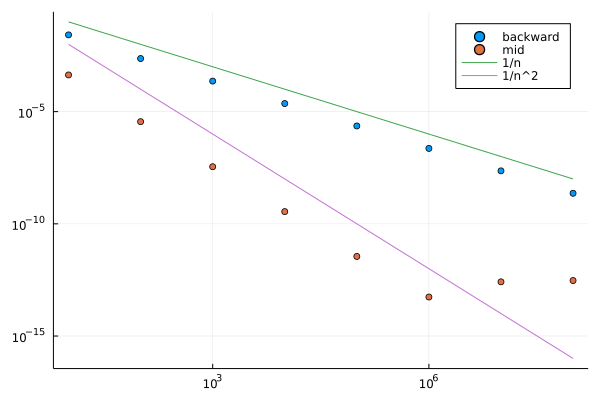

In [3]:
# Error from indefinite integration with c and f
function indefint(x)
    h = step(x) # x[k+1]-x[k]
    n = length(x)
    L = Bidiagonal([1; fill(1/h, n-1)], fill(-1/h, n-1), :L)
end

f = x -> cos(x)

function backward_err(u, c, f, n)
    x = range(0, 1; length = n)
    uᶠ = indefint(x) \ [c; f.(x[2:end])]
    norm(uᶠ - u.(x), Inf)
end

function mid_err(u, c, f, n; mode=Inf)
    x = range(0, 1; length = n)
    m = (x[1:end-1] + x[2:end]) / 2 # midpoints # crossing vectors
    uᵐ = indefint(x) \ [c; f.(m)]
    norm(uᵐ - u.(x), mode)
end

ns = 10 .^ (1:8) # solve up to n = 10 million
scatter(ns, backward_err.(sin, 0, f, ns); xscale=:log10, yscale=:log10, label="backward")
scatter!(ns, mid_err.(sin, 0, f, ns); label="mid")
plot!(ns, ns .^ (-1); label="1/n")
plot!(ns, ns .^ (-2); label="1/n^2")

**Problem 2.2** Implement indefinite-integration 
where we take the average of the two grid points:
$$
{u'(x_{k+1}) + u'(x_k) \over 2} ≈ {u_{k+1} - u_k \over h}
$$
What is the observed rate-of-convergence using the ∞-norm for $f(x) = \cos x$
on the interval $[0,1]$?
Does the method converge if the error is measured in the $1$-norm?

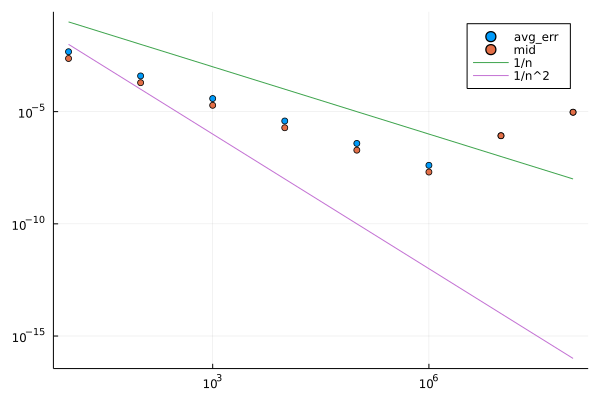

In [4]:
function avg_err(u, c, f, n; mode=Inf)

    x = range(0, 1; length = n)
    m = (f.(x[1:end-1]) + f.(x[2:end])) / 2
    uᵐ = indefint(x) \ [c; m]
    norm(uᵐ - u.(x), mode)
end

ns = 10 .^ (1:8) # solve up to n = 10 million
scatter(ns, avg_err.(sin, 0, f, ns; mode=1); xscale=:log10, yscale=:log10, label="avg_err")
scatter!(ns, mid_err.(sin, 0, f, ns; mode=1); label="mid")
plot!(ns, ns .^ (-1); label="1/n")
plot!(ns, ns .^ (-2); label="1/n^2")
# still converges but bad

## 3. Euler methods

**Problem 3.1** Solve the following ODEs 
using forward and/or backward Euler and increasing $n$, the number of time-steps, 
until $u(1)$ is determined to 3 digits:
$$
\begin{align*}
u(0) &= 1, u'(t) = \cos(t) u(t) + t \\
v(0) &= 1, v'(0) = 0, v''(t) = \cos(t) v(t) + t \\
w(0) &= 1, w'(0) = 0, w''(t) = t w(t) + 2 w(t)^2
\end{align*}
$$
If we increase the initial condition $w(0) = c > 1$, $w'(0)$
the solution may blow up in finite time. Find the smallest positive integer $c$
such that the numerical approximation suggests the equation
does not blow up.

In [ ]:
a = t->cos(t) # u'(t) -a(t)u(t) = f(t)
f = t->t
c = 1

function fEuler(a=a, f=f, c=c ; n=100)
    t = range(0, 1; length=n)
    h = step(t)
    L = Bidiagonal([1; fill(1/h, n-1)], a.(t[1:end-1]) .- 1/h, :L)
    L \ [1; f.(t[1:end-1])]
end

function check1(m=100)
    result = zeros(0)
    for n in range(3, m;step=1)
        t = range(0, 1; length=n)
        append!(result, fEuler(n=n)[2])
    end
    result
end
plot(check1())

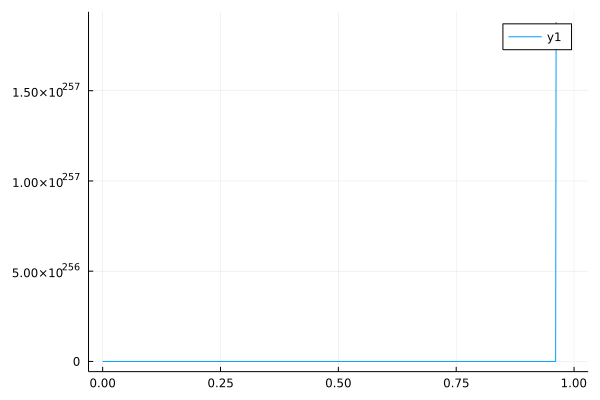

In [40]:
# Rewrite as vectors
# n = 100
# A = t->[0 1; cos(t) 0]
# c₀ = [1.0, 0.0]
# f = t->[0.0, t]

"""
Compute system of equations using forward Euler
# Arguments:
- `n::Integer`: number of time steps
- `c₀::Vector`: initial value
- `A::function`: matrix a(t)
- `f::function`: vector f(t)
- `dims::Integer`: dimension of system
"""
function vecForwardEuler2(n, c₀, A, f; dims=2)
    U = zeros(dims, n) # initial vector 
    t = range(0, 1; length=n)
    h = step(t)
    U[:,1] = c₀
    for k in 1:n-1
        U[:, k+1] = (I + h*A(t[k]))*U[:,k] + h*f(t[k])
    end
    t, U
end
# result = vecForwardEuler(n, c₀, A, f)

# plot(result[1], result[2][1,:])

# Third problem
function vecForwardEuler3(c₀)
    n = 1000
    U = zeros(2, n) # initial vector 
    t = range(0, 1; length=n)
    h = step(t)
    U[:,1] = c₀
    for k in 1:n-1
        U[:, k+1] = (I + h*[0 1; 2*U[1,k]+t[k] 0])*U[:,k]
    end
    plot(t, U[1,:])
end

# for c in 1:10
    
# end
vecForwardEuler3([5 0]) # blows up in finite time

**Problem 3.2⋆** For an evenly spaced grid $t_1, …, t_n$, use the approximation
$$
{u'(t_{k+1}) + u'(t_k) \over 2} ≈ {u_{k+1} - u_k \over h}
$$
to recast
$$
\begin{align*}
u(0) &= c \\
u'(t) &= a(t) u(t) + f(t)
\end{align*}
$$
as a lower bidiagonal linear system. Use forward-substitution to extend this to vector linear problems:
$$
\begin{align*}
𝐮(0) &= 𝐜 \\
𝐮'(t) &= A(t) 𝐮(t) + 𝐟(t)
\end{align*}
$$


**Problem 3.3** Implement the method designed in Problem 3.1 for the negative time Airy equation 
$$
u(0) = 1, u'(0) = 0, u''(t) = -t u(t)
$$
on $[0,50]$.
How many time-steps are needed to get convergence to 1% accuracy (the "eyeball norm")?


In [ ]:
function airy2(n=100)
    t = range(0, 50;length = n)
    c₀ = [1.0, 0.0]
    A = t-> [0 1; -t 0]
    U = zeros(2, n)
    U[:,1] = c₀
    h = step(t)
    for i in 1:n-1
        U[:,i+1] = (((1/h)*I - 0.5*A(t[i]))^-1) * ((1/h)*I + 0.5*A(t[i]))*U[:,i]
    end
    plot(t, U')
end 
airy2(1000000)

**Problem 3.4** Implement Heat on a graph with $m = 50$ nodes with no forcing
and initial condition $u_{m/2}(0) = 1$ and $u_k(0) = 0$, but where the first and last node are fixed
to  zero, that is replace the first and last rows of the differential equation with
the conditions:
$$
u_1(t) = u_m(t) = 0.
$$
Find the time $t$ such that  $\|𝐮(t)\|_∞ <10^{-3}$ to 2 digits.
Hint: Differentiate to recast the conditions as a differential equation.
Vary $n$, the number of time-steps used in Forward Euler, and increase $T$ in the interval $[0,T]$
until the answer doesn't change.
Do a for loop over the time-slices to find the first that satisfies the condition.
(You may wish to call `println` to print the answer and `break` to exit the for loop).

In [4]:
n = 1000
T = 50
m = 50
U = zeros(m, n)
# recasted as reduced differential equation
U[25, 1] = 1 # initial value
t = range(0, T; length = n)
h = step(t)
Δ = SymTridiagonal([-1; fill(-2.0, m-2); -1], ones(m-1))
for i in 1:n-1
    U[:, i+1] = (I + h*Δ)*U[:,i]
    U[1, i+1] = 0
    U[m-1, i+1] = 0
end
for k in 1:n
    x = norm(U[:,k], Inf)
    println("Maximum is ", x, "\n Time is ", k)
    if x < 0.01
        println("Maximum is ", x, "\n Time is ", k)
    end
end

Maximum is 1.0
 Time is 1
Maximum is 0.8998998998998999
 Time is 2
Maximum is 0.8148298448598749
 Time is 3
Maximum is 0.7422823198548875
 Time is 4
Maximum is 0.6801890642436654
 Time is 5
Maximum is 0.6268419268346899
 Time is 6
Maximum is 0.580828245381182
 Time is 7
Maximum is 0.5409780504110355
 Time is 8
Maximum is 0.5063209000720549
 Time is 9
Maximum is 0.4760505636273914
 Time is 10
Maximum is 0.4494961045947272
 Time is 11
Maximum is 0.42609818502693597
 Time is 12
Maximum is 0.4053896320085833
 Time is 13
Maximum is 0.3869794857437936
 Time is 14
Maximum is 0.37053989344958876
 Time is 15
Maximum is 0.35579533097058075
 Time is 16
Maximum is 0.342513729718831
 Time is 17
Maximum is 0.3304991643667582
 Time is 18
Maximum is 0.31958582004388636
 Time is 19
Maximum is 0.3096330093354974
 Time is 20
Maximum is 0.3005210513626444
 Time is 21
Maximum is 0.2921478594305954
 Time is 22
Maximum is 0.28442611162047127
 Time is 23
Maximum is 0.27728090144645334
 Time is 24
Maximum is 0

0.08221592014874562
 Time is 238
Maximum is 0.08204168643244443
 Time is 239
Maximum is 0.08186855597729256
 Time is 240
Maximum is 0.08169651718665198
 Time is 241
Maximum is 0.08152555863385894
 Time is 242
Maximum is 0.08135566905903345
 Time is 243
Maximum is 0.08118683736596173
 Time is 244
Maximum is 0.08101905261904956
 Time is 245
Maximum is 0.08085230404034467
 Time is 246
Maximum is 0.08068658100662636
 Time is 247
Maximum is 0.0805218730465605
 Time is 248
Maximum is 0.08035816983791826
 Time is 249
Maximum is 0.08019546120485681
 Time is 250
Maximum is 0.08003373711526042
 Time is 251
Maximum is 0.07987298767814043
 Time is 252
Maximum is 0.07971320314109229
 Time is 253
Maximum is 0.07955437388780869
 Time is 254
Maximum is 0.07939649043564667
 Time is 255
Maximum is 0.07923954343324804
 Time is 256
Maximum is 0.07908352365821116
 Time is 257
Maximum is 0.07892842201481304
 Time is 258
Maximum is 0.07877422953178045
 Time is 259
Maximum is 0.07862093736010886
 Time is 260


0.05827204505832013
 Time is 471
Maximum is 0.05820991733880473
 Time is 472
Maximum is 0.05814798792139208
 Time is 473
Maximum is 0.05808625575335445
 Time is 474
Maximum is 0.05802471978977197
 Time is 475
Maximum is 0.05796337899345829
 Time is 476
Maximum is 0.05790223233488718
 Time is 477
Maximum is 0.057841278792119935
 Time is 478
Maximum is 0.057780517350733605
 Time is 479
Maximum is 0.0577199470037501
 Time is 480
Maximum is 0.05765956675156606
 Time is 481
Maximum is 0.057599375601883586
 Time is 482
Maximum is 0.057539372569641686
 Time is 483
Maximum is 0.05747955667694859
 Time is 484
Maximum is 0.057419926953014774
 Time is 485
Maximum is 0.057360482434086826
 Time is 486
Maximum is 0.057301222163381946
 Time is 487
Maximum is 0.05724214519102328
 Time is 488
Maximum is 0.057183250573975976
 Time is 489
Maximum is 0.0571245373759839
 Time is 490
Maximum is 0.05706600466750718
 Time is 491
Maximum is 0.0570076515256603
 Time is 492
Maximum is 0.056949477034151055
 Time 

702
Maximum is 0.047650638030470135
 Time is 703
Maximum is 0.047616649259692403
 Time is 704
Maximum is 0.04758273311352385
 Time is 705
Maximum is 0.04754888933360296
 Time is 706
Maximum is 0.04751511766285173
 Time is 707
Maximum is 0.04748141784546742
 Time is 708
Maximum is 0.04744778962691451
 Time is 709
Maximum is 0.04741423275391652
 Time is 710
Maximum is 0.04738074697444805
 Time is 711
Maximum is 0.047347332037726814
 Time is 712
Maximum is 0.047313987694205764
 Time is 713
Maximum is 0.047280713695565225
 Time is 714
Maximum is 0.047247509794705156
 Time is 715
Maximum is 0.04721437574573744
 Time is 716
Maximum is 0.0471813113039782
 Time is 717
Maximum is 0.047148316225940255
 Time is 718
Maximum is 0.047115390269325534
 Time is 719
Maximum is 0.04708253319301766
 Time is 720
Maximum is 0.04704974475707449
 Time is 721
Maximum is 0.04701702472272074
 Time is 722
Maximum is 0.04698437285234073
 Time is 723
Maximum is 0.04695178890947109
 Time is 724
Maximum is 0.04691927

0.04131964555172745
 Time is 934
Maximum is 0.04129747269672196
 Time is 935
Maximum is 0.04127533543031659
 Time is 936
Maximum is 0.04125323365670856
 Time is 937
Maximum is 0.04123116728045021
 Time is 938
Maximum is 0.041209136206447304
 Time is 939
Maximum is 0.041187140339957365
 Time is 940
Maximum is 0.04116517958658789
 Time is 941
Maximum is 0.04114325385229476
 Time is 942
Maximum is 0.041121363043380474
 Time is 943
Maximum is 0.04109950706649255
 Time is 944
Maximum is 0.04107768582862181
 Time is 945
Maximum is 0.04105589923710078
 Time is 946
Maximum is 0.04103414719960203
 Time is 947
Maximum is 0.04101242962413651
 Time is 948
Maximum is 0.04099074641905198
 Time is 949
Maximum is 0.040969097493031396
 Time is 950
Maximum is 0.04094748275509125
 Time is 951
Maximum is 0.040925902114580054
 Time is 952
Maximum is 0.04090435548117671
 Time is 953
Maximum is 0.04088284276488896
 Time is 954
Maximum is 0.040861363876051784
 Time is 955
Maximum is 0.04083991872532589
 Time 

In [5]:
for n in 10000:10000
    for T in 1000:1000
        m = 50
        U = zeros(m, n)
        # recasted as reduced differential equation
        U[25, 1] = 1 # initial value
        t = range(0, T; length = n)
        h = step(t)
        Δ = SymTridiagonal([-1; fill(-2.0, m-2); -1], ones(m-1))
        for i in 1:n-1
            U[:, i+1] = (I + h*Δ)*U[:,i]
            U[1, i+1] = 0
            U[m-1, i+1] = 0
        end
        for k in 1:n
            x = norm(U[:,k], Inf)
            if x < 0.001
                println("Maximum is ", x, "\n Time is ", k, "\n T is ", T, "\n n is ", n)
                break
            end
        end
    end
end

Maximum is 0.0009996305283118307
 Time is 8709
 T is 1000
 n is 10000


**Problem 3.5** Consider the equation
$$
u(1) = 1, u'(t) = -10u(t)
$$
What behaviour do you observe on $[0,10]$ of forward, backward, and that of Problem 3.1
with a step-size of 0.5? What happens if you decrease the step-size to $0.01$? (Hint: you may wish to do a plot and scale the $y$-axis logarithmically,)

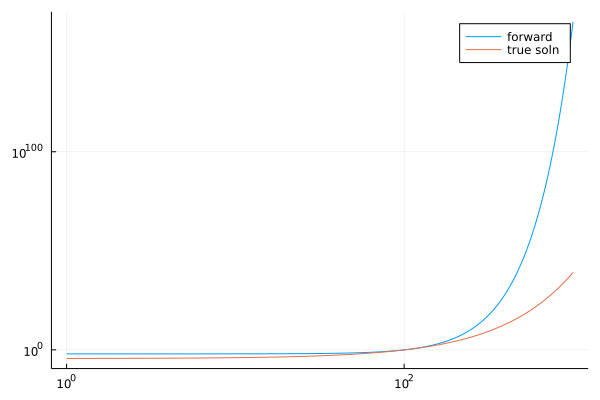

In [64]:
# lambda(t) = exp(10(t-1))
h = 0.01
function fEuler(a = x -> -10*x, f = t -> 0*t, c = 1, h = h)
    t = range(0, 10; step = h)
    n = length(t)
    val_idx = Int(1/h) # the index of the intial value problem

    # L = Bidiagonal([1; fill(1/h, n-1)], a.(t[1:end-1]) .- 1/h, :L)

    M = Tridiagonal(
        [zeros(val_idx-1); a.(t[val_idx:n-1]) .- 1/h], 
            [a.(t[1:val_idx-1]) .- 1/h; 1; fill(1/h, n-val_idx)], 
                [fill(1/h, val_idx-1); zeros(n-val_idx)]
    )
    ft1 = f.(t[1:val_idx-1])
    ft2 = f.(t[val_idx+1:end])

    M \ [ft1; 1; ft2]
    
end
t = range(0, 10; step = h)
forward = fEuler()
plot(forward, xscale=:log10, yscale=:log10, label="forward")

plot!(exp.(10 .* (t .- 1)), xaxis=:log, yaxis=:log, label="true soln")

# plot(back, xscale=:log10, yscale=:log10, label="backward")
# plot!(forward, xscale=:log10, yscale=:log10, label="forward")